# Deeper Networks for Image Classification


## Inception V3 Model for MNIST Image Classification

- Code by: Kaviraj Gosaye
- Student ID: 220575371

In [1]:
# GPU details
output = !nvidia-smi
for line in output:
    print(line)
    if line.strip() == "":
        break

Sat May  4 13:54:43 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 552.22                 Driver Version: 552.22         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3070 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   43C    P8             14W /  105W |     680MiB /   8192MiB |      3%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import psutil
# Get virtual memory information
virtual_memory = psutil.virtual_memory()
v_mem = virtual_memory.available / (1024 ** 3)

# Print available virtual memory
print("Available virtual memory:", v_mem)

Available virtual memory: 9.499713897705078


### 0. Imports

In [3]:
# import libraries
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
from torchinfo import summary
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from datetime import datetime

### 1. Data Loading and Preprocessing

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))])

# load mnist dataset
train_set = torchvision.datasets.MNIST(root='../datasets', train=True, download=True, transform=transform)
test_set = torchvision.datasets.MNIST(root='../datasets', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True, num_workers=8)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False, num_workers=8)

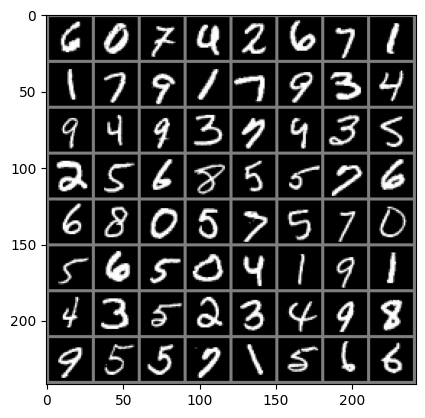

In [5]:
# extract one sample from the training set
dataiter = iter(train_loader)

images, labels = next(dataiter)

# plot the image
def imshow(img):
    # reverse normalization
    img = img / 2 + 0.5
    # convert tensor to numpy array
    npimg = img.numpy()
    # rearrange the dimensions to match matplotlib format
    # matplotlib:   H x W x C
    # torch:        C x H x W
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# show images
imshow(torchvision.utils.make_grid(images))

### 2. Model Building

In [6]:
class BasicConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return F.relu(x, inplace=True)

class InceptionA(nn.Module):
    def __init__(self, in_channels, pool_features):
        super(InceptionA, self).__init__()
        self.branch1x1 = BasicConv2d(in_channels, 64, kernel_size=1)

        self.branch5x5_1 = BasicConv2d(in_channels, 48, kernel_size=1)
        self.branch5x5_2 = BasicConv2d(48, 64, kernel_size=5, padding=2)

        self.branch3x3dbl_1 = BasicConv2d(in_channels, 64, kernel_size=1)
        self.branch3x3dbl_2 = BasicConv2d(64, 96, kernel_size=3, padding=1)
        self.branch3x3dbl_3 = BasicConv2d(96, 96, kernel_size=3, padding=1)

        self.branch_pool = BasicConv2d(in_channels, pool_features, kernel_size=1)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch5x5 = self.branch5x5_1(x)
        branch5x5 = self.branch5x5_2(branch5x5)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = self.branch3x3dbl_3(branch3x3dbl)

        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch5x5, branch3x3dbl, branch_pool]
        return torch.cat(outputs, 1)

class InceptionB(nn.Module):
    def __init__(self, in_channels):
        super(InceptionB, self).__init__()
        self.branch3x3 = BasicConv2d(in_channels, 384, kernel_size=3, stride=2)

        self.branch3x3dbl_1 = BasicConv2d(in_channels, 64, kernel_size=1)
        self.branch3x3dbl_2 = BasicConv2d(64, 96, kernel_size=3, padding=1)
        self.branch3x3dbl_3 = BasicConv2d(96, 96, kernel_size=3, stride=2)

    def forward(self, x):
        branch3x3 = self.branch3x3(x)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = self.branch3x3dbl_3(branch3x3dbl)

        branch_pool = F.max_pool2d(x, kernel_size=3, stride=2)

        outputs = [branch3x3, branch3x3dbl, branch_pool]
        return torch.cat(outputs, 1)

class InceptionC(nn.Module):
    def __init__(self, in_channels, channels_7x7):
        super(InceptionC, self).__init__()
        self.branch1x1 = BasicConv2d(in_channels, 192, kernel_size=1)

        c7 = channels_7x7
        self.branch7x7_1 = BasicConv2d(in_channels, c7, kernel_size=1)
        self.branch7x7_2 = BasicConv2d(c7, c7, kernel_size=(1, 7), padding=(0, 3))
        self.branch7x7_3 = BasicConv2d(c7, 192, kernel_size=(7, 1), padding=(3, 0))

        self.branch7x7dbl_1 = BasicConv2d(in_channels, c7, kernel_size=1)
        self.branch7x7dbl_2 = BasicConv2d(c7, c7, kernel_size=(7, 1), padding=(3, 0))
        self.branch7x7dbl_3 = BasicConv2d(c7, c7, kernel_size=(1, 7), padding=(0, 3))
        self.branch7x7dbl_4 = BasicConv2d(c7, c7, kernel_size=(7, 1), padding=(3, 0))
        self.branch7x7dbl_5 = BasicConv2d(c7, 192, kernel_size=(1, 7), padding=(0, 3))

        self.branch_pool = BasicConv2d(in_channels, 192, kernel_size=1)

    
    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch7x7 = self.branch7x7_1(x)
        branch7x7 = self.branch7x7_2(branch7x7)
        branch7x7 = self.branch7x7_3(branch7x7)

        branch7x7dbl = self.branch7x7dbl_1(x)
        branch7x7dbl = self.branch7x7dbl_2(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_3(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_4(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_5(branch7x7dbl)
        
        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)
        
        outputs = [branch1x1, branch7x7, branch7x7dbl, branch_pool]
        return torch.cat(outputs, 1)
    
class InceptionD(nn.Module):

    def __init__(self, input_channels):
        super(InceptionD, self).__init__()

        self.branch3x3_1 = BasicConv2d(input_channels, 192, kernel_size=1)
        self.branch3x3_2 = BasicConv2d(192, 320, kernel_size=3, stride=2)
        
        self.branch7x7_1 = BasicConv2d(input_channels, 192, kernel_size=1)
        self.branch7x7_2 = BasicConv2d(192, 192, kernel_size=(1, 7), padding=(0, 3))
        self.branch7x7_3 = BasicConv2d(192, 192, kernel_size=(7, 1), padding=(3, 0))
        self.branch7x7_4 = BasicConv2d(192, 192, kernel_size=3, stride=2)


    def forward(self, x):

        branch3x3 = self.branch3x3_1(x)
        branch3x3 = self.branch3x3_2(branch3x3)

        branch7x7 = self.branch7x7_1(x)
        branch7x7 = self.branch7x7_2(branch7x7)
        branch7x7 = self.branch7x7_3(branch7x7)
        branch7x7 = self.branch7x7_4(branch7x7)

        branch_pool = F.max_pool2d(x, kernel_size=3, stride=2)

        outputs = [branch3x3, branch7x7, branch_pool]

        return torch.cat(outputs, 1)
    
class InceptionE(nn.Module):

    def __init__(self, input_channels):
        super(InceptionE, self).__init__()

        self.branch1x1 = BasicConv2d(input_channels, 320, kernel_size=1)

        self.branch3x3_1 = BasicConv2d(input_channels, 384, kernel_size=1)
        self.branch3x3_2a = BasicConv2d(384, 384, kernel_size=(1, 3), padding=(0, 1))
        self.branch3x3_2b = BasicConv2d(384, 384, kernel_size=(3, 1), padding=(1, 0))

        self.branch3x3dbl_1 = BasicConv2d(input_channels, 448, kernel_size=1)
        self.branch3x3dbl_2 = BasicConv2d(448, 384, kernel_size=3, padding=1)
        self.branch3x3dbl_3a = BasicConv2d(384, 384, kernel_size=(1, 3), padding=(0, 1))
        self.branch3x3dbl_3b = BasicConv2d(384, 384, kernel_size=(3, 1), padding=(1, 0))

        self.branch_pool = BasicConv2d(input_channels, 192, kernel_size=1)

    def forward(self, x):

        branch1x1 = self.branch1x1(x)

        branch3x3 = self.branch3x3_1(x)
        branch3x3 = [
            self.branch3x3_2a(branch3x3),
            self.branch3x3_2b(branch3x3)
        ]
        branch3x3 = torch.cat(branch3x3, 1)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = [
            self.branch3x3dbl_3a(branch3x3dbl),
            self.branch3x3dbl_3b(branch3x3dbl),
        ]
        branch3x3dbl = torch.cat(branch3x3dbl, 1)

        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch3x3, branch3x3dbl, branch_pool]
        return torch.cat(outputs, 1)
    
class InceptionAux(nn.Module):
    def __init__( self, in_channels, num_classes):
        super(InceptionAux, self).__init__()
    
        self.conv0 = BasicConv2d(in_channels, 128, kernel_size=1)
        self.conv1 = BasicConv2d(128, 768, kernel_size=5)
        self.conv1.stddev = 0.01
        self.fc = nn.Linear(768, num_classes)
        self.fc.stddev = 0.001

    def forward(self, x):

        x = F.avg_pool2d(x, kernel_size=5, stride=3)
        x = self.conv0(x)
        x = self.conv1(x)
        # Adaptive average pooling
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [7]:
class InceptionV3(nn.Module):
    # setting use_aux to True will add an auxiliary classifier
    def __init__(self, use_aux=False, num_classes=100):
        super(InceptionV3, self).__init__()
        
        self.use_aux = use_aux

        # same naming convention used for consistency
        # replaced channels=3 with 1, kernel size 3 with 1, added stride=1
        self.Conv2d_1a_3x3 = BasicConv2d(1, 32, kernel_size=1, padding=1, stride=1)
        self.Conv2d_2a_3x3 = BasicConv2d(32, 32, kernel_size=3, padding=1)
        self.Conv2d_2b_3x3 = BasicConv2d(32, 64, kernel_size=3, padding=1)
        
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        
        self.Conv2d_3b_1x1 = BasicConv2d(64, 80, kernel_size=1)
        self.Conv2d_4a_3x3 = BasicConv2d(80, 192, kernel_size=3)

        # replace maxpool with average pool
        self.avgpool2 = nn.AdaptiveAvgPool2d((7, 7))
        
        # inception modules
        self.Mixed_5b = InceptionA(192, pool_features=32)
        self.Mixed_5c = InceptionA(256, pool_features=64)
        self.Mixed_5d = InceptionA(288, pool_features=64)

        # inception modules
        self.Mixed_6a = InceptionB(288)
        self.Mixed_6b = InceptionC(768, channels_7x7=128)
        self.Mixed_6c = InceptionC(768, channels_7x7=160)
        self.Mixed_6d = InceptionC(768, channels_7x7=160)
        self.Mixed_6e = InceptionC(768, channels_7x7=192)

        # removed auxiliary layer
        # if use_aux:
        #     self.AuxLogits = InceptionAux(768, num_classes)

        # inception modules
        self.Mixed_7a = InceptionD(768)
        self.Mixed_7b = InceptionE(1280)
        self.Mixed_7c = InceptionE(2048)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout2d()
        self.linear = nn.Linear(2048, num_classes)

    def forward(self, x):

        x = self.Conv2d_1a_3x3(x)
        x = self.Conv2d_2a_3x3(x)
        x = self.Conv2d_2b_3x3(x)

        x = self.maxpool1(x)
        
        x = self.Conv2d_3b_1x1(x)
        x = self.Conv2d_4a_3x3(x)

        x = self.avgpool2(x)

        x = self.Mixed_5b(x)
        x = self.Mixed_5c(x)
        x = self.Mixed_5d(x)

        x = self.Mixed_6a(x)

        x = self.Mixed_6b(x)
        x = self.Mixed_6c(x)
        x = self.Mixed_6d(x)
        x = self.Mixed_6e(x)

        # if self.use_aux:
        #     aux = self.AuxLogits(x)

        x = self.Mixed_7a(x)
        x = self.Mixed_7b(x)
        x = self.Mixed_7c(x)

        x = self.avgpool(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)

        return x

In [8]:
# setting the device to cuda if available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [9]:
# creating instance of model and setting it to the device
inception_v3 = InceptionV3(num_classes=10).to(device)

In [10]:
# visualize the model
info = summary(inception_v3, input_size=(1, 1, 28, 28), col_names = ('input_size', 'output_size', 'num_params', 'kernel_size'))
print(info)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape
InceptionV3                              [1, 1, 28, 28]            [1, 10]                   --                        --
├─BasicConv2d: 1-1                       [1, 1, 28, 28]            [1, 32, 30, 30]           --                        --
│    └─Conv2d: 2-1                       [1, 1, 28, 28]            [1, 32, 30, 30]           32                        [1, 1]
│    └─BatchNorm2d: 2-2                  [1, 32, 30, 30]           [1, 32, 30, 30]           64                        --
├─BasicConv2d: 1-2                       [1, 32, 30, 30]           [1, 32, 30, 30]           --                        --
│    └─Conv2d: 2-3                       [1, 32, 30, 30]           [1, 32, 30, 30]           9,216                     [3, 3]
│    └─BatchNorm2d: 2-4                  [1, 32, 30, 30]           [1, 32, 30, 30]           64                        --
├─Basi

### 3. Model Training and Evaluation

In [11]:
# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(inception_v3.parameters(), lr=0.0001)

# open log file in write mode
log_file = open("../logs/inceptionv3_mnist_log.txt", "w")

start = time.time()

num_epochs = 10

train_losses = []
train_accs = []
test_losses = []
test_accs = []

test_correct = 0
total = 0

predicted_labels = []
true_labels = []


for epoch in range(num_epochs):
    running_train_loss = 0.0
    running_train_acc = 0.0
    running_test_loss = 0.0
    running_test_acc = 0.0
    correct = 0.0
    avg_test_loss = 0
    batch_loss = 0.0
    batch_acc = 0.0

    # setting the model to train mode
    inception_v3.train()
    
    # loop over the training set
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = inception_v3(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # cumulative loss
        running_train_loss += loss.item()
        # batch loss for logging
        batch_loss += loss.item()

        # cumulative accuracy
        pred = outputs.argmax(dim=1, keepdim=True)

        # reshaping the labels to match the shape of the predictions
        # comparing the predictions to the labels using element-wise comparison
        # summing the correct predictions
        correct = pred.eq(labels.view_as(pred)).sum().item()
        running_train_acc += 100. * (correct / len(pred))

        # batch accuracy for logging
        batch_acc += 100. * (correct / len(pred))
        # printing the average loss every 100 mini-batches
        if i % 100 == 99:
             # Get current timestamp
            timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
            # Write loss to log file
            log_file.write(f"{timestamp} - [{epoch + 1}, {i + 1}] loss: {batch_loss/100} accuracy: {batch_acc/100}\n")
            print(f"[{epoch + 1}, {i + 1}] loss: {batch_loss/100} accuracy: {batch_acc/100}")
            batch_loss = 0.0
            batch_acc = 0.0

    train_accs.append(running_train_acc/len(train_loader))
    train_losses.append(running_train_loss/len(train_loader))


    ##############################

    # setting the model to evaluation mode
    inception_v3.to(device)
    inception_v3.eval()


    # Disable gradient calculation
    with torch.no_grad():
        # Using test set
        for i, data in enumerate(test_loader, 0):

            images, labels = data[0].to(device), data[1].to(device)
            
            # Forward pass
            outputs = inception_v3(images)
            
            # Calculate the test loss
            loss = criterion(outputs, labels)
            avg_test_loss += loss.item()

            # Get the predicted labels
            _, predicted = torch.max(outputs.data, 1)
            
            # Update the total and correct predictions
            total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
            
            # Append the predicted and true labels to be used for confusion matrix
            predicted_labels.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            
            running_test_loss += loss.item()
            running_test_acc += 100 * test_correct / total

           
        test_losses.append(running_test_loss/len(test_loader))
        test_accs.append(running_test_acc/len(test_loader))

training_time = f'{(time.time() - start)/60.0:.2f}'
log_file.write(f"Finished Training after {training_time} minutes\n")
print(f"Finished Training after {training_time} minutes")

# Close the log file
log_file.close()

[1, 100] loss: 1.346349835395813 accuracy: 54.09375
[1, 200] loss: 0.3851878469437361 accuracy: 87.875
[1, 300] loss: 0.2588926187902689 accuracy: 92.015625
[1, 400] loss: 0.17943030059337617 accuracy: 94.546875
[1, 500] loss: 0.1486158469133079 accuracy: 95.21875
[1, 600] loss: 0.15566231997683644 accuracy: 94.984375
[1, 700] loss: 0.13386693561449647 accuracy: 95.890625
[1, 800] loss: 0.12558617609553038 accuracy: 96.453125
[1, 900] loss: 0.102263889266178 accuracy: 96.6875
[2, 100] loss: 0.08482833036221564 accuracy: 97.5625
[2, 200] loss: 0.07785388897173107 accuracy: 97.65625
[2, 300] loss: 0.08079188800416887 accuracy: 97.578125
[2, 400] loss: 0.08112204427365213 accuracy: 97.8125
[2, 500] loss: 0.07535274829249829 accuracy: 97.890625
[2, 600] loss: 0.07717114908620715 accuracy: 97.65625
[2, 700] loss: 0.07043512024916708 accuracy: 97.859375
[2, 800] loss: 0.06209336019586772 accuracy: 98.1875
[2, 900] loss: 0.07800689116120338 accuracy: 97.734375
[3, 100] loss: 0.045175838619470

In [12]:
# save model after training
torch.save(inception_v3, "../Models/inception_v3_mnist.pth")

### 4. Model Results and Plots

In [13]:
# print final accuracy
# get the final value of train_acc

print(f"Train Accuracy: {train_accs[-1]} %")
print(f"Test Accuracy: {test_accs[-1]} %")

print(f"Train Loss: {train_losses[-1]}")
print(f"Test Loss: {test_losses[-1]}")

Train Accuracy: 99.20209221748401 %
Test Accuracy: 98.53975107279473 %
Train Loss: 0.028726899197689
Test Loss: 0.02745451526851675


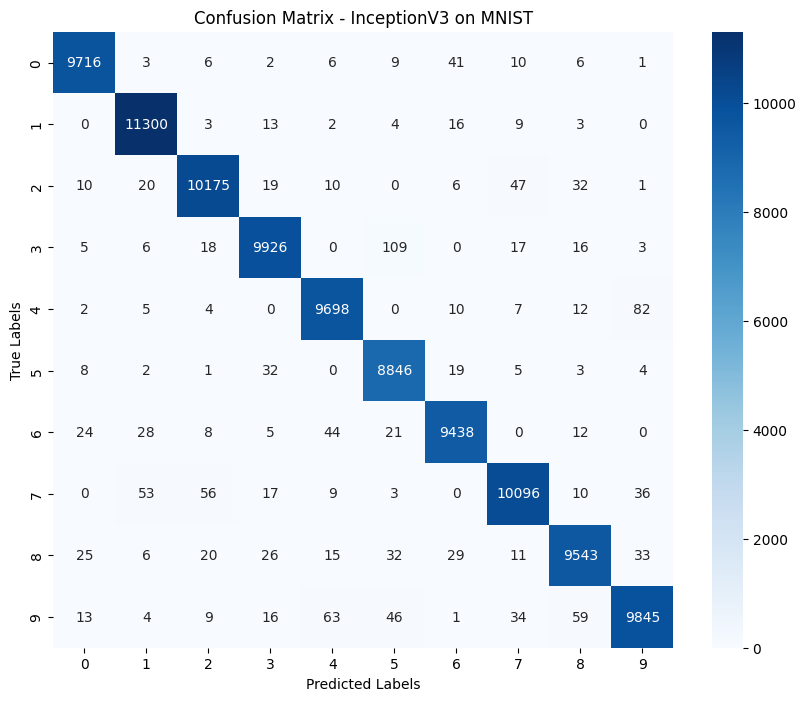

In [14]:
# Create the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - InceptionV3 on MNIST")
plt.show()

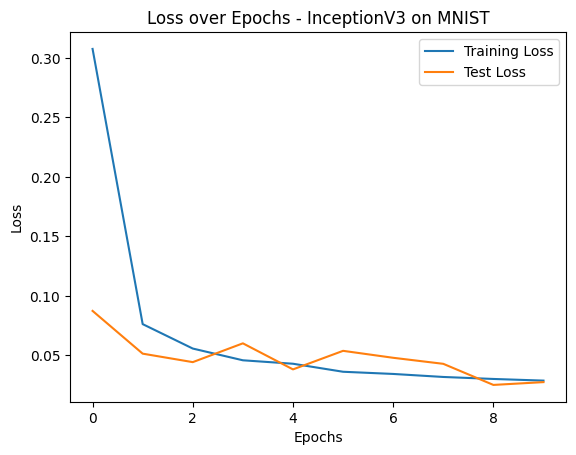

In [15]:
# plot the training loss and test loss over epochs
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss over Epochs - InceptionV3 on MNIST")
plt.legend()
# save the plot
plt.savefig("./plots/Loss_Inception_MNIST.png")
plt.show()

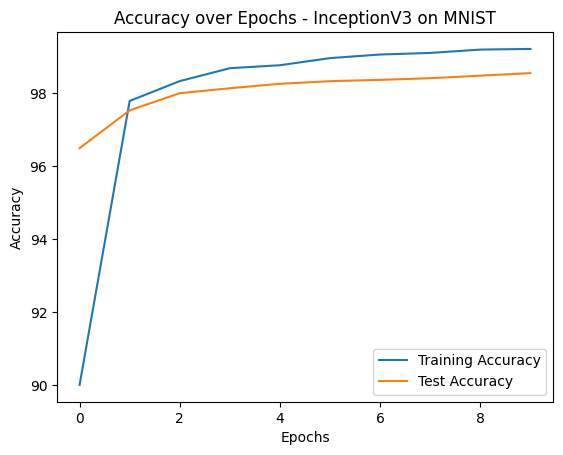

In [16]:
# plot the training accuracy and test accuracy over epochs
plt.plot(train_accs, label="Training Accuracy")
plt.plot(test_accs, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs - InceptionV3 on MNIST")
plt.legend()
plt.savefig("./plots/Acc_Inception_MNIST.png")
plt.show()

In [17]:
# print classification report
cr = classification_report(true_labels, predicted_labels)
print(cr)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      9800
           1       0.99      1.00      0.99     11350
           2       0.99      0.99      0.99     10320
           3       0.99      0.98      0.98     10100
           4       0.98      0.99      0.99      9820
           5       0.98      0.99      0.98      8920
           6       0.99      0.99      0.99      9580
           7       0.99      0.98      0.98     10280
           8       0.98      0.98      0.98      9740
           9       0.98      0.98      0.98     10090

    accuracy                           0.99    100000
   macro avg       0.99      0.99      0.99    100000
weighted avg       0.99      0.99      0.99    100000



### 5. Model Testing

In [18]:
# loading some images from the test set
testloader = torch.utils.data.DataLoader(test_set, batch_size=30,shuffle=False)

dataiter = iter(testloader)
images, true_labels = next(dataiter)

In [19]:
# classes of mnist
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

In [20]:
# plotter function to plot the images
def plotter(images, true_labels, predicted_labels):
    correct = 0
    num_images = len(images)
    num_rows = (num_images) // 5
    fig, axs = plt.subplots(num_rows, 5, figsize=(15, 20))
    # setting the title
    fig.suptitle('True Label - [Predicted Labels]', fontsize=20)

    for ind in range(num_images):
        # plot image
        img = images[ind].permute(1, 2, 0) / 2 + 0.5
        ax = axs[ind // 5, ind % 5]
        ax.imshow(img, cmap='gray')

        # left - true label, right - predicted label
        if classes[true_labels[ind]] == classes[predicted_labels[ind]]:
            color = 'green'
            title = classes[true_labels[ind]] + ' - [' + classes[predicted_labels[ind]] + ']'
            ax.set_title(title, color=color)
            correct += 1
        else:
            color = 'red'
            title = classes[true_labels[ind]] + ' - [' + classes[predicted_labels[ind]] + ']'
            ax.set_title(title, color=color)        

    plt.tight_layout(pad=2.0)
    plt.show()
    print('Number of correct predictions: ', correct)
    print('Number of wrong predictions: ', num_images - correct)

In [21]:
# use model to predict images label
inception_v3.eval()
inception_v3.to('cpu')
outputs = inception_v3(images)
_, predicted_labels = torch.max(outputs, 1)

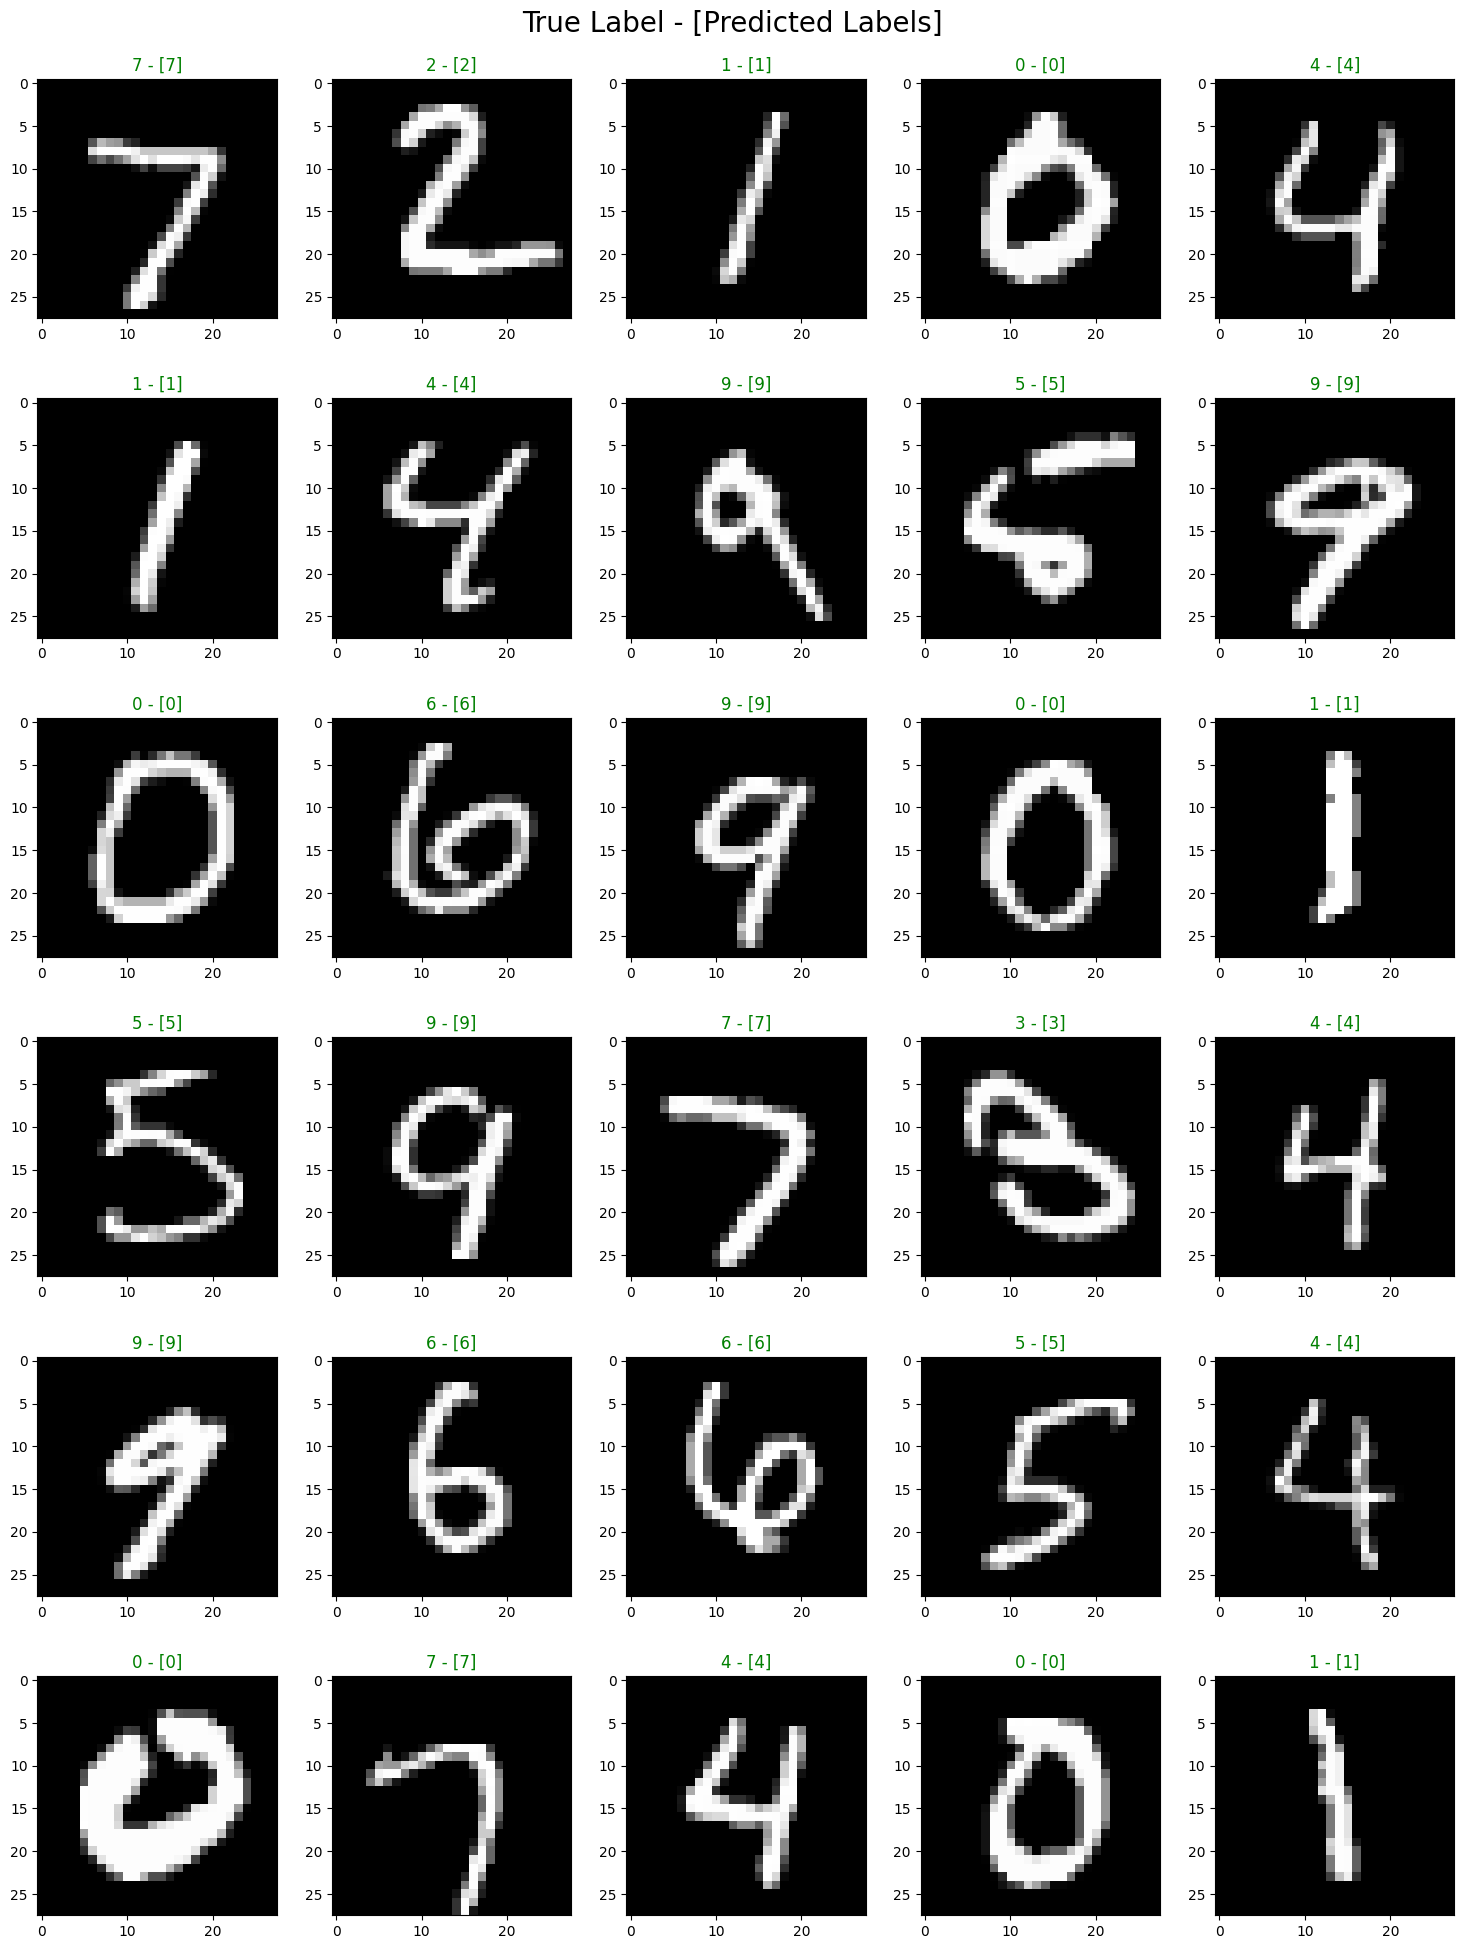

Number of correct predictions:  30
Number of wrong predictions:  0


In [22]:
# plot the images and predictions
plotter(images, true_labels, predicted_labels)